# Neural Machine Translation - Assignment 2

In this task, you will develop a neural machine translation (NMT) system to translate text from one language into another. For this, you will need to choose the data to train the models, perform data processing and train a sequence2sequence neural model.


## Section 1- Data Collection and Preprocessing 


---


**Task 1  (5 marks)**

---

There are few datasets to train an NMT system available from Tatoeba Project (http://www.manythings.org/anki/) or OPUS project (http://opus.nlpl.eu/).

*  Download a language pair (preferably European language) and **extract** the file(s) and upload it to CoLab
*  Create a list of lines by splitting the text file at every occurrence accordingly, i.e. source and target language and remove copyright information
*  Print number of sentences
*  Limit the number of sentences to 10,000 lines (but more than 5,000 lines)
*  Split the data into train and test [You can split validation set here or while training use Keras validation_split option]
*  Print 100th sentence in original script[ not unicode] for source and target language

Student Name : Anitha Govindaraju
Student ID : 19230254

REFERENCES:
https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os, sys

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import nltk
from nltk.translate.bleu_score import SmoothingFunction
smoothing = SmoothingFunction().method4


In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Open and read file for Romanian language. Creating a list of lines by splitting the text file at every occurance accordingly as \n.
filename="/content/drive/My Drive/Colab Notebooks/ron.txt"
with open(filename , 'r') as roman_file:
  lines=roman_file.read().split('\n')

In [3]:
#Removing the copyright information
newlines = [x.split('CC-BY')[0] for x in lines]
print(newlines)

['Hi.\tBună!\t', 'Run!\tFugi!\t', 'Who?\tCine?\t', 'Fire!\tFoc!\t', 'Help!\tAjutor!\t', 'Jump!\tSări!\t', 'Stop!\tOprește-te!\t', 'Wait!\tAșteaptă!\t', 'Hello!\tSalut.\t', 'Hello!\tBună!\t', 'Hurry!\tHaide!\t', 'Hurry!\tGrăbește-te!\t', 'Relax.\tCalmează-te.\t', 'Smile.\tZâmbește.\t', 'Attack!\tAtacă!\t', 'Attack!\tAtacați!\t', 'Cheers!\tNoroc!\t', 'Cheers!\tSănătate!\t', 'Cheers!\tNoroc bun!\t', 'Freeze!\tStai pe loc!\t', 'Get up.\tRidică-te.\t', 'Really?\tSerios?\t', 'Ask Tom.\tÎntreabă-l pe Tom.\t', 'Awesome!\tMaxim!\t', 'Awesome!\tExcelent!\t', 'Call me.\tSună-mă.\t', 'Get out!\tPleacă de aici!\t', 'Get out.\tPleacă de aici!\t', 'Go away!\tPleacă!\t', 'Go away.\tLasă-mă.\t', 'Goodbye!\tLa revedere!\t', 'Hold on.\tRezistă.\t', 'I agree.\tSunt de acord.\t', "I'm Tom.\tSunt Tom.\t", "I'm ill.\tSunt bolnav.\t", "I'm sad.\tSunt trist.\t", "It's OK.\tE OK.\t", 'Keep it.\tPăstreaz-o.\t', 'Keep it.\tPăstrează-l.\t', 'Open up.\tDeschide!\t', 'Perfect!\tPerfect!\t', 'Tell me.\tSpune-mi.\t', 

In [0]:
#Limiting the number of sentences to 10,000 lines
del(newlines[10000:])

In [5]:
#Printing the number of sentences
print("Number of sentences: ",len(newlines))

#Printing 100th sentence
print(newlines[100])

Number of sentences:  10000
Is it bad?	E rău?	


**Task 2 (5 marks)** 

---

* Add '<bof\>' to denote beginning of sentence and '<eos\>' to denote the end of the sentence to each target line.
* Preprocess (word tokenisation, lowercasing) the text.

In [0]:
# Adding bof at the start of target text and eos at the end
input_texts = list()
target_texts = list()
target_text_source = list()

num_samples = 10000
for line in newlines[: min(num_samples, len(newlines) - 1)]:
  input_text, target, space = line.split('\t') 
  target_text = target + ' <eos>'
  target_text_2 = '<bof> ' + target
  input_texts.append(input_text)
  target_texts.append(target_text)
  target_text_source.append(target_text_2)
      

In [0]:
#Preprocessing the text - Word tokenizaion and lowercasing
input_vocab = set()
target_vocab = set()

for in_sentence in input_texts:
  in_texts = [in_word.lower() for in_word in in_sentence.split()]
  for in_i in in_texts:
    input_vocab.add(in_i)
for out_sentence in target_texts:
  out_texts = [out_word.lower() for out_word in out_sentence.split()]
  for out_i in out_texts:
    target_vocab.add(out_i)

In [0]:
NUM_SENTENCES = 10000
MAX_NUM_WORDS = 10000
EMBEDDING_SIZE = 100

In [0]:
#Source text tokenizing
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_texts)
input_integer_seq = input_tokenizer.texts_to_sequences(input_texts)

word2idx_inputs = input_tokenizer.word_index

In [0]:
#Target text tokenizing
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(target_texts + target_text_source)
output_integer_seq = output_tokenizer.texts_to_sequences(target_texts)
output_input_integer_seq = output_tokenizer.texts_to_sequences(target_text_source)
                                                           
word2idx_outputs = output_tokenizer.word_index
num_words_output = len(word2idx_outputs) + 1


In [11]:
#Printing source and target text details
Source_vocabulary = sorted(list(input_vocab))
target_vocabulary = sorted(list(target_vocab))
num_source_tokens = len(input_vocab)
num_target_tokens = len(target_vocab)
max_source_seq_length = max([len(txt) for txt in input_integer_seq])
max_target_seq_length = max([len(txt) for txt in output_integer_seq])

print('Number of samples:', len(input_texts))
print('Number of unique source language tokens:', num_source_tokens)
print('Number of unique target language tokens:', num_target_tokens)
print('Max sequence length of source language:', max_source_seq_length)
print('Max sequence length of target language:', max_target_seq_length)
print("Source Vocabulary",Source_vocabulary)
print("Max number of words:", len(Source_vocabulary))
print("Target Vocabulary",target_vocabulary)

Number of samples: 9999
Number of unique source language tokens: 7093
Number of unique target language tokens: 9927
Max sequence length of source language: 14
Max sequence length of target language: 17
Source Vocabulary ['"a', '"because', '"did', '"do', '"don\'t', '"global', '"here', '"i', '"i\'ll', '"i\'ve', '"it\'s', '"itch."', '"no', '"no,', '"no."', '"not', '"pass', '"she', '"so', '"thank', '"thanks', '"the', '"trust', '"when', '"where', '"who', '"why', '"yes,', '$20', "'australia?'", "'em", '1,000', '10', '10,000', '100', '10:00', '11', '119.', '12', '13-year', '15', '15%.', '15.', '18', '1846.', '1865.', '1876', '1897,', '1914.', '1920,', '1929,', '1945.', '1952.', '1974.', '1988.', '2', '20', '20%', '2013.', '20th.', '25', '2:30', '2:30.', '3', '3,000', '3.', '30', '33', '330', '40', '5', '5%', '5.', '50', '50%', '500', '54.', '6', '6:30.', '75%', '76,000', '7:00', '7:00.', '85', '8:30', 'a', "a's.", 'a.m.', 'aback', 'aback.', 'abandoned', 'abated.', 'abating.', 'aberration.', '

**Task 3 (5 marks)** 

---

---

*  Assign each unique word an integer value (5 marks).
*  Create word embedding for your vocabulary using pre-trained Glove embeddings (10 marks) (http://nlp.stanford.edu/data/glove.6B.zip)
* Print the first line of the embeddings (see below) 

In [0]:
#Assign each unique word an integer value
input_vocab_index = dict([(in_word,in_i) for in_i, in_word in enumerate(input_vocab)])
target_vocab_index= dict([(out_word,out_i) for out_i, out_word in enumerate(target_vocab)])

In [12]:
#Padding for encoder sequence
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_source_seq_length)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences.shape: (9999, 14)
encoder_input_sequences[172]: [  0   0   0   0   0   0   0   0   0   0   0   0  83 165]


In [13]:
print(word2idx_inputs["i'm"])
print(word2idx_inputs["ill"])

26
920


In [14]:
#Padding for decoder sequence
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_target_seq_length, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[45]:", decoder_input_sequences[45])

decoder_input_sequences.shape: (9999, 17)
decoder_input_sequences[45]: [   2   19 3983    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


In [15]:
#Padding for decoder sequence
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_target_seq_length, padding='post')
print("decoder_input_sequences.shape:", decoder_output_sequences.shape)
print("decoder_input_sequences[172]:", decoder_output_sequences[172])

decoder_input_sequences.shape: (9999, 17)
decoder_input_sequences[172]: [ 140 2402    1    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


In [0]:
#Creating a embedding matrix using glove 100 dimention data
embeddings_dict = {}
with open("/content/drive/My Drive/Colab Notebooks/glove.6B.100d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [17]:
print(embeddings_dict["ill"])


[ 0.12648    0.1366     0.22192   -0.025204  -0.7197     0.66147
  0.48509    0.057223   0.13829   -0.26375   -0.23647    0.74349
  0.46737   -0.462      0.20031   -0.26302    0.093948  -0.61756
 -0.28213    0.1353     0.28213    0.21813    0.16418    0.22547
 -0.98945    0.29624   -0.62476   -0.29535    0.21534    0.92274
  0.38388    0.55744   -0.14628   -0.15674   -0.51941    0.25629
 -0.0079678  0.12998   -0.029192   0.20868   -0.55127    0.075353
  0.44746   -0.71046    0.75562    0.010378   0.095229   0.16673
  0.22073   -0.46562   -0.10199   -0.80386    0.45162    0.45183
  0.19869   -1.6571     0.7584    -0.40298    0.82426   -0.386
  0.0039546  0.61318    0.02701   -0.3308    -0.095652  -0.082164
  0.7858     0.13394   -0.32715   -0.31371   -0.20247   -0.73001
 -0.49343    0.56445    0.61038    0.36777   -0.070182   0.44859
 -0.61774   -0.18849    0.65592    0.44797   -0.10469    0.62512
 -1.9474    -0.60622    0.073874   0.50013   -1.1278    -0.42066
 -0.37322   -0.50538    0

In [0]:
#Performing word embeddings for the input Romanian file
from numpy import zeros
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [19]:
print(embedding_matrix[920])

[ 0.12648     0.1366      0.22192    -0.025204   -0.71969998  0.66147
  0.48508999  0.057223    0.13829    -0.26374999 -0.23647     0.74348998
  0.46737    -0.46200001  0.20031001 -0.26302001  0.093948   -0.61756003
 -0.28213     0.1353      0.28213     0.21813001  0.16418     0.22547001
 -0.98944998  0.29624    -0.62475997 -0.29534999  0.21534     0.92273998
  0.38387999  0.55743998 -0.14628001 -0.15673999 -0.51941001  0.25628999
 -0.0079678   0.12998    -0.029192    0.20868    -0.55127001  0.075353
  0.44746    -0.71046001  0.75562     0.010378    0.095229    0.16673
  0.22073001 -0.46562001 -0.10199    -0.80386001  0.45162001  0.45183
  0.19869    -1.65709996  0.75840002 -0.40298     0.82426    -0.38600001
  0.0039546   0.61317998  0.02701    -0.3308     -0.095652   -0.082164
  0.78579998  0.13394    -0.32714999 -0.31371    -0.20247    -0.73000997
 -0.49342999  0.56445003  0.61037999  0.36776999 -0.070182    0.44859001
 -0.61773998 -0.18849     0.65592003  0.44797    -0.10469     0.

In [21]:
print(target_texts[1], input_texts[1])

Fugi! <eos> Run!


## Section 2 Translation Model training



---



**Task 4 (15 marks)**
* Provide code for the encoder using Keras LSTM (5 marks)
* Provide code for the decoder using Keras LSTM (5 marks)
* Train the sequence2sequence (encoder-decoder) model (5 marks) 


In [0]:
#Initializing variables
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256

In [0]:
#Defining embedding layer
embedding_layer = tf.keras.layers.Embedding(num_words, 100, weights=[embedding_matrix], input_length=max_source_seq_length)

In [0]:
#One hot encoding of decoder
decoder_targets_one_hot = np.zeros((len(input_texts), max_target_seq_length, num_words_output),dtype='float32'
)

In [25]:
decoder_targets_one_hot.shape

(9999, 17, 9930)

In [0]:
for i, j in enumerate(decoder_output_sequences):
    
    for k, word in enumerate(j):
        decoder_targets_one_hot[i, k, word] = 1

In [0]:
#LSTM for encoder
encoder_inputs_ph = tf.keras.layers.Input(shape=(max_source_seq_length,))

x = embedding_layer(encoder_inputs_ph)
encoder = tf.keras.layers.LSTM(256, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [0]:
#LSTM for decoder
decoder_inputs_ph = tf.keras.layers.Input(shape=(max_target_seq_length,))

decoder_embedding = tf.keras.layers.Embedding(num_words_output, 255)
decoder_inputs_x = decoder_embedding(decoder_inputs_ph)

decoder_lstm = tf.keras.layers.LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [0]:
decoder_dense = tf.keras.layers.Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [0]:
#model compilation
model = tf.keras.models.Model([encoder_inputs_ph,
  decoder_inputs_ph], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
#model fit
history = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=128,
    epochs=10,
    validation_split=0.2,
)

Epoch 1/10
63/63 [==============================] - 53s 837ms/step - loss: 1.6746 - accuracy: 0.7530 - val_loss: 3.4872 - val_accuracy: 0.5594
Epoch 2/10
63/63 [==============================] - 52s 832ms/step - loss: 1.5656 - accuracy: 0.7637 - val_loss: 3.4192 - val_accuracy: 0.5666
Epoch 3/10
63/63 [==============================] - 53s 840ms/step - loss: 1.4664 - accuracy: 0.7725 - val_loss: 3.3672 - val_accuracy: 0.5735
Epoch 4/10
63/63 [==============================] - 53s 838ms/step - loss: 1.3793 - accuracy: 0.7799 - val_loss: 3.2906 - val_accuracy: 0.5778
Epoch 5/10
63/63 [==============================] - 53s 834ms/step - loss: 1.2992 - accuracy: 0.7877 - val_loss: 3.2557 - val_accuracy: 0.5831
Epoch 6/10
63/63 [==============================] - 53s 837ms/step - loss: 1.2273 - accuracy: 0.7949 - val_loss: 3.2320 - val_accuracy: 0.5855
Epoch 7/10
63/63 [==============================] - 53s 836ms/step - loss: 1.1615 - accuracy: 0.8019 - val_loss: 3.2064 - val_accuracy: 0.5890

In [0]:
model.save('eng_rom-nl.h5')

## Section 3 Testing

---

**Task 5 (20 marks)**

* Use the trained model to translate the text from the source into the target language (10 marks). 
* Use the test/evaluation set (see Section 1) and perform an automatic evaluation with the BLEU metric (10 marks). 
You can use the NLTK library to calculate BLEU.

In [0]:
#Loading the model accordingly with generated weights
model = tf.keras.models.Model([encoder_inputs_ph,
  decoder_inputs_ph], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.load_weights('eng_rom-nl.h5')

In [0]:
#Encoder model defination
encoder_model = tf.keras.models.Model(encoder_inputs_ph, encoder_states)


In [0]:
#Decoder model defination
decoder_state_input_h = tf.keras.layers.Input(shape=(256,))
decoder_state_input_c = tf.keras.layers.Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [0]:
decoder_inputs_l = tf.keras.layers.Input(shape=(1,))
decoder_inputs_l_x = decoder_embedding(decoder_inputs_l)

In [0]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_l_x, initial_state=decoder_states_inputs)

In [0]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [0]:
decoder_model = tf.keras.models.Model(
    [decoder_inputs_l] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [0]:
#Word to index converter
index_word_input = {v:k for k, v in word2idx_inputs.items()}
index_word_target = {v:k for k, v in word2idx_outputs.items()}

In [0]:
#Translater functionality
def decoder_func(input_value):
    states_value = encoder_model.predict(input_value)
    target_value = np.zeros((1, 1))
    target_value[0, 0] = word2idx_outputs['<bof>']
    target_eof = word2idx_outputs['<eos>']
    output_sentence = []
    for _ in range(max_target_seq_length):
        output_tokens, h, c = decoder_model.predict([target_value] + states_value)
        index_value = np.argmax(output_tokens[0, 0, :])
        if target_eof == index_value:
            break
        word = ''
        if index_value > 0:
            word = index_word_target[index_value]
            output_sentence.append(word)
        target_value[0, 0] = index_value
        states_value = [h, c]
    return ' '.join(output_sentence)

In [106]:
#Printing input and decoded sentence
seq_index = np.random.choice(len(input_texts))
input_seq = encoder_input_sequences[seq_index:seq_index+1]
decoded_sentence = decoder_func(input_seq)
print('-')
print('Input sentence:', input_texts[seq_index])
print('Decoded sentence:', decoded_sentence)

-
Input sentence: They lost again.
Decoded sentence: ei au fost în parte.


In [177]:
#Testing with reference and candidate 
reference = target_texts[i].split()
candidate = decoded_sentence.split()
reference = reference[:-1]
print(reference,candidate)

['Bună!'] ['este', 'vine', 'în', 'masă.']


In [0]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train, y_test = train_test_split(encoder_input_sequences, decoder_input_sequences , test_size=0.2)

In [200]:
# 1-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
score = sentence_bleu(reference, candidate, weights=(0.35,0.35,0.20,0.10))
print(score)

0.48296816446242286


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [0]:
#Bleu function
def blue_score_func(ref,candi):
    try:
        return nltk.translate.bleu_score.sentence_bleu([ref], candi,smoothing_function = smoothing,weights=((0.35,0.35,0.20,0.10)))
    except:
        return 0

In [0]:
encoder_input_sequences_list = encoder_input_sequences.tolist()
X_test = X_test[:50]
scores = list()
for i, j in enumerate(X_test):
    encoder_index = encoder_input_sequences_list.index(j.tolist())
    encoded_seq = encoder_input_sequences[encoder_index:encoder_index+1] 
    decoaded = decoder_func(encoded_seq)
    reference = target_texts[encoder_index].split()
    candidate = decoaded.split()
    reference = reference[:-1]
    score = blue_score_func(reference,candidate)
    scores.append(score)

In [75]:
bleu_scores = np.array(scores)
print("Average Bleu Score: ",bleu_scores.mean() )

Average Bleu Score:  0.12722762182899344


**Task 5 (40 Marks)** Sequence2Sequence

* Extend the existing Seq2Seq model with an attention mechanism [Discussed in Class]
* Create sequence2sequence model with attention (15 marks)
* Train the model with the same data from Section 1 (10 marks)
* Translate the evaluation set using the sequence2sequence attention model (10 marks)
* Evaluate the translations made with the sequence2sequence attention model and compare it with the model without attention using BLEU (5 marks)

In [0]:
#LSTM for encoder
encoder_inputs_attention = tf.keras.layers.Input(shape=(max_source_seq_length,))
encoder_layer_attention = tf.keras.layers.Embedding(num_words, 100, weights=[embedding_matrix])(encoder_inputs_attention)
encoder_lstm = LSTM(256, return_sequences=True)(encoder_layer_attention)
encoder_attention = encoder_lstm[:,-1,:]

In [0]:
#LSTM for decoder
decoder_inputs_attention= tf.keras.layers.Input(shape=(max_target_seq_length,))
decoder_layer_attention = tf.keras.layers.Embedding(num_words_output, 100)(decoder_inputs_attention)
decoder_lstm = tf.keras.layers.LSTM(256, return_sequences=True, unroll=True)(decoder_layer_attention, initial_state=[encoder_attention,encoder_attention])

In [0]:
# Attention layer with dot and activation function
enc_dec_att = tf.keras.layers.dot([decoder_lstm, encoder_lstm], axes=[2, 2])
enc_dec_att = tf.keras.layers.Activation('softmax', name='attention')(enc_dec_att)

In [0]:
dot_attention = tf.keras.layers.dot([enc_dec_att, encoder_lstm], axes=[2,1])

concat_attention = tf.keras.layers.concatenate([dot_attention, decoder_lstm])

final_attention = tf.keras.layers.TimeDistributed(Dense(64, activation="tanh"))(concat_attention)
final_attention = tf.keras.layers.TimeDistributed(Dense(num_words_output, activation="softmax"))(final_attention)

In [0]:
model = tf.keras.models.Model(inputs =[encoder_inputs_attention, decoder_inputs_attention], outputs =[final_attention])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [179]:
history_attention = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=128,
    epochs=10,
    validation_split=0.2,
)  
model.save('eng_rom_attention.h5')

Epoch 1/10
63/63 [==============================] - 54s 860ms/step - loss: 1.1862 - accuracy: 0.8035 - val_loss: 3.1458 - val_accuracy: 0.5924
Epoch 2/10
63/63 [==============================] - 53s 848ms/step - loss: 1.1047 - accuracy: 0.8110 - val_loss: 3.1769 - val_accuracy: 0.5928
Epoch 3/10
63/63 [==============================] - 53s 848ms/step - loss: 1.0382 - accuracy: 0.8176 - val_loss: 3.1499 - val_accuracy: 0.5936
Epoch 4/10
63/63 [==============================] - 53s 847ms/step - loss: 0.9775 - accuracy: 0.8242 - val_loss: 3.1670 - val_accuracy: 0.5931
Epoch 5/10
63/63 [==============================] - 58s 922ms/step - loss: 0.9203 - accuracy: 0.8310 - val_loss: 3.1746 - val_accuracy: 0.5943
Epoch 6/10
63/63 [==============================] - 54s 855ms/step - loss: 0.8668 - accuracy: 0.8380 - val_loss: 3.1645 - val_accuracy: 0.5947
Epoch 7/10
63/63 [==============================] - 55s 869ms/step - loss: 0.8154 - accuracy: 0.8451 - val_loss: 3.1948 - val_accuracy: 0.5939

In [0]:
# decoding for attention model
def decoder_attention(input_attention):
    decoder_input = np.ones(shape=(input_attention.shape[0], max_target_seq_length))
    decoder_input[:,0] = word2idx_outputs['<bof>']
    for i in range(1, max_target_seq_length):
        output_ = model.predict([input_attention, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output_[:,i]
    decoder_output = decoder_input[:,1:]
    decoder_output = np.array(decoder_output,dtype=int)
    sequence = decoder_output[0]
    text = ''
    for i in sequence:
        if i == 0:
            continue
        if index_word_target[i] == '<eos>':
            break
        else:
            text += ' ' + index_word_target[i]
    return text.strip().rstrip()

In [95]:
#Printing input and decoded sentence
seq_index_attention = np.random.choice(len(target_texts))
input_seq_attention = encoder_input_sequences[seq_index_attention:seq_index_attention+1]
#input_seq_attention = encoder_input_sequences[5000:5000+1]
#decoded_sentence = decoder_attention(input_seq_attention)
decoded_sentence = decoder_func(input_seq_attention)
print('-')
print('Input sentence:', input_texts[seq_index_attention])
print('Decoded sentence:', decoded_sentence)

-
Input sentence: Tom kept me company.
Decoded sentence: tom a spus pe mary.


In [0]:

X_test = X_test[:50]
bleu_scores_att = list()
for i_attention,j_attention in enumerate(X_test):
    encoder_index_attention = encoder_input_sequences_list.index(j_attention.tolist())
    encoder_seq_attention = encoder_input_sequences[encoder_index_attention:encoder_index_attention+1] 
    decoded_attention = decoder_attention(encoder_seq_attention)
    reference_attention = target_texts[encoder_index_attention].split()
    candidate_attentiom = decoded_attention.split()
    reference_attention = reference_attention[:-1]
    score_attention = blue_score_func(reference_attention,candidate_attentiom)
    bleu_scores_att.append(score_attention)

In [100]:
bleu_scores_attention = np.array(bleu_scores_att)
print("Average Bleu Score: ",bleu_scores_attention.mean() )

Average Bleu Score:  0.10961899383621468


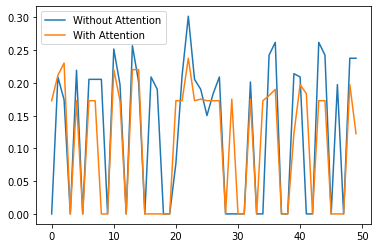

In [102]:
import matplotlib.pyplot as plot
plot.plot(bleu_scores,label='Without Attention' )
plot.plot(bleu_scores_attention, label='With Attention')
plot.legend()